In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import pickle 
from tqdm import tqdm

import automata as dfa
import utils

## Global Variables

In [2]:
ATT_PATH = "./data/languages/att/"
DATA_PATH = "./data/Small/"
NAMES_PATH = "./names.txt"

BATCH_SIZE = 200

N_EPOCH = 150
EPOCH_VERBOSE = 50
LEARNING_RATES = 0.005

torch.manual_seed(689)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

## Load the datas

In [3]:
names, extensions = utils.lang_names(NAMES_PATH)
print(names, extensions, sep="\n")

datas = dict()
automata = dict()
for name in names:
    datas[name], automata[name] = utils.data_automata_loading(ATT_PATH, DATA_PATH, name, extensions, return_automata=True)

['04.03.TLTT.2.3.0', '04.03.TLTT.4.2.3', '04.04.Reg.0.0.9', '04.04.Zp.2.1.0', '16.04.TLT.2.1.4', '16.16.LT.4.1.5', '16.16.SP.2.1.0', '64.64.SF.0.0.0', '64.64.SL.4.1.0']
['_Dev', '_TestLA', '_TestLR', '_TestSA', '_TestSR', '_Train']


In [4]:
def makeloader(name:str, datas)-> tuple[DataLoader, list[torch.Tensor]]:
    train = DataLoader(datas[name]["_Train"], BATCH_SIZE, shuffle=True)
    test = next(iter(DataLoader(datas[name]["_Dev"], len(datas[name]["_Dev"]))))

    return train, test

## Model

In [4]:
class LossInvParam(nn.Module):
    "Custom loss with inverse parameters as dampling arguments."

    def __init__(self, alpha = 0.1, loss = nn.BCELoss()) -> None:
        super().__init__()
        self.loss = loss
        self.alpha = alpha
        self.model = None

    def set_model(self, model:nn.Module):
        self.model = model
    
    def forward(self, predictions, labels):
        if self.model is None:
            raise ValueError("'model' haven't been set up in the loss.")
        invsum = 0
        for parameters in self.model.parameters():
            invsum += torch.linalg.matrix_norm(parameters)**2
        invsum = 1/torch.sqrt(invsum)
        return self.loss(predictions, labels) + invsum * self.alpha

In [5]:
def single_model_training(model:nn.Module, optim:torch.optim.Optimizer, loss:nn.Module, target:list[torch.Tensor], trainloader:DataLoader, test:list[torch.Tensor]):

    statsdict = utils.initstats(utils.STATS_NAMES)

    for batchepoch in range(N_EPOCH//EPOCH_VERBOSE):
        for _ in tqdm(range(EPOCH_VERBOSE), desc=f"Epoch {batchepoch*EPOCH_VERBOSE + 1} to {(batchepoch+1)*EPOCH_VERBOSE}...", ncols=75):
            for words, lengths, labels in trainloader:
                labels = labels.to(dtype = torch.float32)

                out = model(words, lengths)

                newloss = loss(out, labels)
                newloss.backward()
                statsdict["losses"].append(newloss.item())

                stats = utils.stats(model, target, LEARNING_RATES)
                statsdict["l2"].append(stats[0])
                statsdict["linf"].append(stats[1])
                statsdict["linedist"].append(stats[2])
                statsdict["targetdist"].append(stats[3])
                

                optim.step()
                optim.zero_grad()

            with torch.no_grad():
                predictions = model.predict(test[0], test[1])
                statsdict["acc"].append(torch.sum(predictions == test[2].reshape(-1), dim=0).item() * 100 / len(test[2]))
        print(f"Done! Trainloss: {statsdict['losses'][-1]:.6f}, Test accuracy: {statsdict['acc'][-1]:.4f}")

    return statsdict



def train_and_stats(name:str, datas:dict[dict[dfa.TorchData]], automaton:dfa.DFA, loss = nn.BCELoss(), optimizer = torch.optim.Adam, returnmodel=False):
    
    
    trainloader, test = makeloader(name, datas)
    target = dfa.sigmoid_to_tanh(dfa.dfa2srn(automaton.transition.T, automaton.finites))

    noparam = dfa.AutomataRNN(automaton, device=DEVICE).to(DEVICE)
    optim = optimizer(noparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    if isinstance(loss, LossInvParam):
        loss.set_model(noparam)

    statsnoparam = single_model_training(noparam, optim, loss, target, trainloader, test)

    print("\nNon parametrized RNN done!\n")

    withparam = dfa.ParametrizeRNN(automaton, device=DEVICE).to(DEVICE)

    optim = optimizer(withparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    if isinstance(loss, LossInvParam):
        loss.set_model(withparam)

    statsparam = single_model_training(withparam, optim, loss, target, trainloader, test)
    print("\nParametrized RNN done!")

    if returnmodel:
        return (statsnoparam, noparam), (statsparam, withparam)
    else:
        return statsnoparam, statsparam
            

In [6]:
def save_stats(path:str, all_stats, **parameters):
    with open(path, "wb") as file:
        pickle.dump([parameters, all_stats], file)

## Training

In [11]:
(statsnoparam, noparam), (statsparam, withparam) = train_and_stats(names[1], datas, automata[names[1]], loss= LossInvParam(), returnmodel=True)

Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:13<00:00,  3.61it/s]


Done! Trainloss: 0.632333, Test accuracy: 67.2000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:13<00:00,  3.61it/s]


Done! Trainloss: 0.382844, Test accuracy: 87.3000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:14<00:00,  3.51it/s]


Done! Trainloss: 0.174595, Test accuracy: 92.3000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:14<00:00,  3.38it/s]


Done! Trainloss: 0.994859, Test accuracy: 61.7000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:14<00:00,  3.52it/s]


Done! Trainloss: 0.856246, Test accuracy: 62.6000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:14<00:00,  3.49it/s]

Done! Trainloss: 0.800087, Test accuracy: 63.9000

Parametrized RNN done!


In [43]:
all_stats = dict()
for name in names:
    print(f"{name} training...")
    all_stats[name] = train_and_stats(name, datas, automata[name], optimizer=torch.optim.SGD, loss = dfa.Binary_nthRoot_Loss())#, loss = LossInvParam(alpha=1))
    save_stats("saved_mlreg_stats2.pkl", all_stats, lr = LEARNING_RATES, epoch = N_EPOCH, optim = "Adam", loss = "nthLoss", nth=2, batch_size = BATCH_SIZE)


04.03.TLTT.2.3.0 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:12<00:00,  4.13it/s]


Done! Trainloss: 0.706133, Test accuracy: 52.2000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:11<00:00,  4.32it/s]


Done! Trainloss: 0.707090, Test accuracy: 52.6000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:11<00:00,  4.31it/s]


Done! Trainloss: 0.705045, Test accuracy: 52.7000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:12<00:00,  3.96it/s]


Done! Trainloss: 0.705464, Test accuracy: 49.6000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:11<00:00,  4.23it/s]


Done! Trainloss: 0.706858, Test accuracy: 49.6000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:11<00:00,  4.19it/s]


Done! Trainloss: 0.706561, Test accuracy: 49.6000

Parametrized RNN done!
04.03.TLTT.4.2.3 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:13<00:00,  3.73it/s]


Done! Trainloss: 0.708678, Test accuracy: 50.0000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:12<00:00,  3.88it/s]


Done! Trainloss: 0.707785, Test accuracy: 50.0000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:13<00:00,  3.80it/s]


Done! Trainloss: 0.705142, Test accuracy: 50.0000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:13<00:00,  3.61it/s]


Done! Trainloss: 0.705822, Test accuracy: 50.6000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:13<00:00,  3.68it/s]


Done! Trainloss: 0.707179, Test accuracy: 50.6000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:13<00:00,  3.60it/s]


Done! Trainloss: 0.706573, Test accuracy: 50.6000

Parametrized RNN done!
04.04.Reg.0.0.9 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:24<00:00,  2.02it/s]


Done! Trainloss: 0.706790, Test accuracy: 50.3000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:24<00:00,  2.04it/s]


Done! Trainloss: 0.706843, Test accuracy: 50.4000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:23<00:00,  2.08it/s]


Done! Trainloss: 0.706007, Test accuracy: 50.6000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:24<00:00,  2.05it/s]


Done! Trainloss: 0.707089, Test accuracy: 52.0000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:24<00:00,  2.07it/s]


Done! Trainloss: 0.707093, Test accuracy: 52.0000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:24<00:00,  2.05it/s]


Done! Trainloss: 0.707137, Test accuracy: 52.0000

Parametrized RNN done!
04.04.Zp.2.1.0 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:07<00:00,  6.27it/s]


Done! Trainloss: 0.706240, Test accuracy: 49.5000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:08<00:00,  6.23it/s]


Done! Trainloss: 0.704782, Test accuracy: 48.9000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:07<00:00,  6.33it/s]


Done! Trainloss: 0.704807, Test accuracy: 49.3000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:08<00:00,  6.22it/s]


Done! Trainloss: 0.706762, Test accuracy: 49.9000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:08<00:00,  6.14it/s]


Done! Trainloss: 0.707731, Test accuracy: 49.9000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:08<00:00,  6.09it/s]


Done! Trainloss: 0.706851, Test accuracy: 49.9000

Parametrized RNN done!
16.04.TLT.2.1.4 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [01:14<00:00,  1.49s/it]


Done! Trainloss: 0.707005, Test accuracy: 46.8000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [01:14<00:00,  1.49s/it]


Done! Trainloss: 0.707478, Test accuracy: 46.4000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [01:11<00:00,  1.43s/it]


Done! Trainloss: 0.706556, Test accuracy: 46.9000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [01:08<00:00,  1.36s/it]


Done! Trainloss: 0.707272, Test accuracy: 50.3000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [01:18<00:00,  1.57s/it]


Done! Trainloss: 0.707237, Test accuracy: 50.4000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [01:15<00:00,  1.52s/it]


Done! Trainloss: 0.706989, Test accuracy: 50.4000

Parametrized RNN done!
16.16.LT.4.1.5 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [02:05<00:00,  2.50s/it]


Done! Trainloss: 0.707470, Test accuracy: 48.4000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [02:05<00:00,  2.50s/it]


Done! Trainloss: 0.706792, Test accuracy: 48.7000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [02:05<00:00,  2.52s/it]


Done! Trainloss: 0.707264, Test accuracy: 48.1000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [01:59<00:00,  2.40s/it]


Done! Trainloss: 0.707144, Test accuracy: 52.5000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [01:54<00:00,  2.29s/it]


Done! Trainloss: 0.707138, Test accuracy: 52.5000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [01:54<00:00,  2.29s/it]


Done! Trainloss: 0.707049, Test accuracy: 52.5000

Parametrized RNN done!
16.16.SP.2.1.0 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:20<00:00,  2.42it/s]


Done! Trainloss: 0.708040, Test accuracy: 51.4000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:21<00:00,  2.37it/s]


Done! Trainloss: 0.705984, Test accuracy: 52.1000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:21<00:00,  2.38it/s]


Done! Trainloss: 0.706320, Test accuracy: 52.7000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:20<00:00,  2.41it/s]


Done! Trainloss: 0.706903, Test accuracy: 53.5000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:21<00:00,  2.34it/s]


Done! Trainloss: 0.706634, Test accuracy: 53.5000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:20<00:00,  2.39it/s]


Done! Trainloss: 0.706808, Test accuracy: 53.5000

Parametrized RNN done!
64.64.SF.0.0.0 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [03:45<00:00,  4.50s/it]


Done! Trainloss: 0.707009, Test accuracy: 48.8000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [03:44<00:00,  4.50s/it]


Done! Trainloss: 0.707263, Test accuracy: 49.3000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [03:45<00:00,  4.50s/it]


Done! Trainloss: 0.706874, Test accuracy: 49.8000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [03:47<00:00,  4.54s/it]


Done! Trainloss: 0.707060, Test accuracy: 52.0000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [03:47<00:00,  4.54s/it]


Done! Trainloss: 0.707063, Test accuracy: 52.0000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [03:46<00:00,  4.54s/it]


Done! Trainloss: 0.707066, Test accuracy: 52.0000

Parametrized RNN done!
64.64.SL.4.1.0 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [02:11<00:00,  2.63s/it]


Done! Trainloss: 0.706196, Test accuracy: 50.7000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [02:24<00:00,  2.89s/it]


Done! Trainloss: 0.706336, Test accuracy: 53.8000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [02:18<00:00,  2.78s/it]


Done! Trainloss: 0.706287, Test accuracy: 54.9000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [02:14<00:00,  2.69s/it]


Done! Trainloss: 0.707120, Test accuracy: 48.1000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [02:21<00:00,  2.82s/it]


Done! Trainloss: 0.707118, Test accuracy: 48.1000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [02:21<00:00,  2.83s/it]

Done! Trainloss: 0.707109, Test accuracy: 48.1000

Parametrized RNN done!


In [15]:
with open("saved_mlreg_stats1.pkl", 'rb') as file:
    parameters, all_stats = pickle.load(file)

In [16]:
parameters #16.16.SP.2.1.0

{'lr': 0.01, 'epoch': 150, 'optim': 'Adam', 'loss': 'BCE', 'batch_size': 200}

In [12]:
parameters #04.03.TLTT.4.2.3

{'lr': 0.001,
 'epoch': 150,
 'optim': 'Adam',
 'loss': 'LossInvParam+BCELoss',
 'alpha': 1,
 'batch_size': 100}

In [8]:
parameters #04.04.Zp.2.1.0

{'lr': 0.005,
 'epoch': 150,
 'optim': 'SGD',
 'loss': 'nthLoss',
 'nth': 2,
 'batch_size': 200}

## Plots

In [ ]:
statsnoparam, statsparam = all_stats[names[0]]
#utils.plot_stats(statsnoparam)
#utils.plot_stats(statsparam)
print(names[0])
utils.plot_stats(statsnoparam, statsparam)

04.03.TLTT.2.3.0


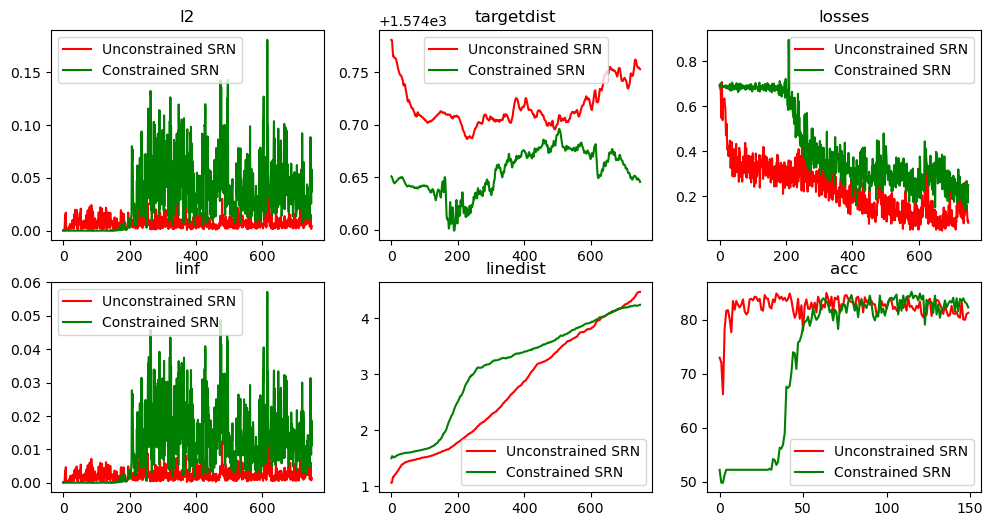

04.03.TLTT.4.2.3


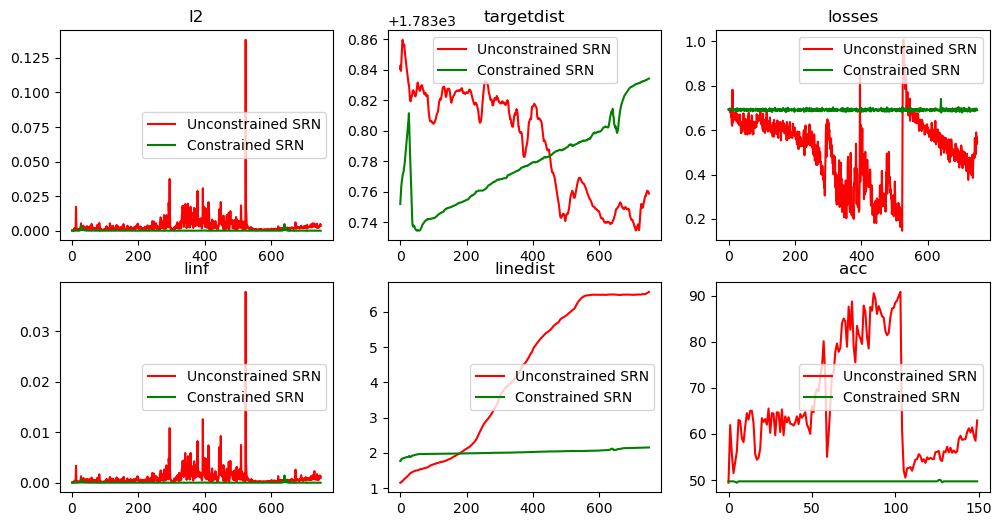

04.04.Reg.0.0.9


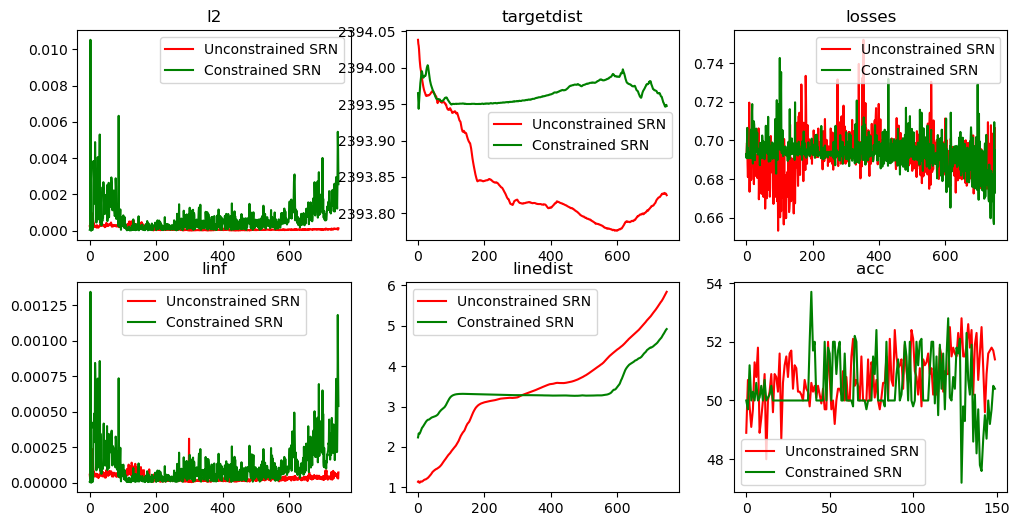

04.04.Zp.2.1.0


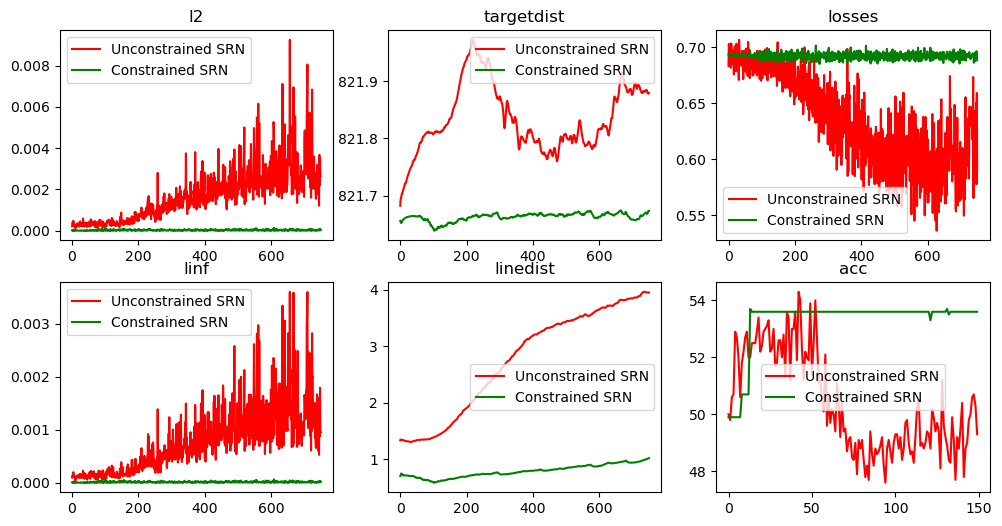

16.04.TLT.2.1.4


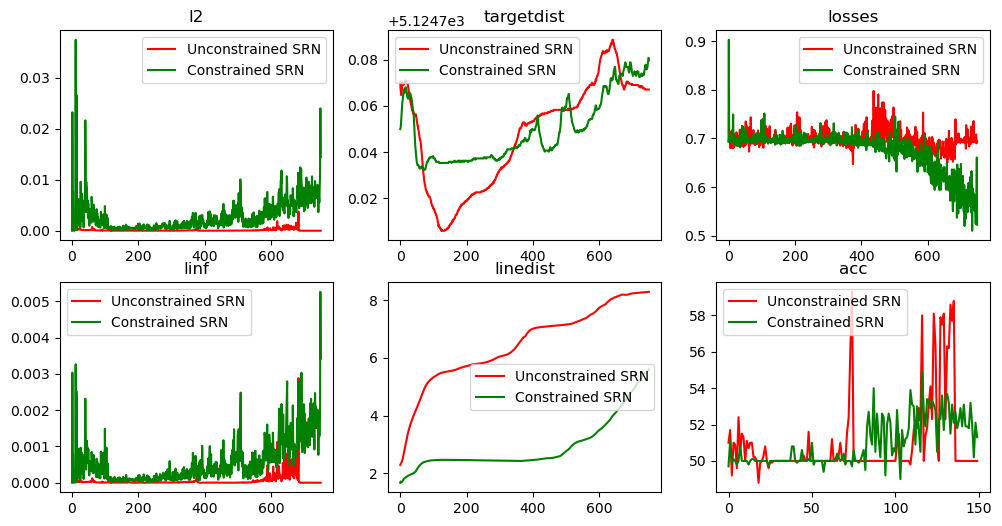

16.16.LT.4.1.5


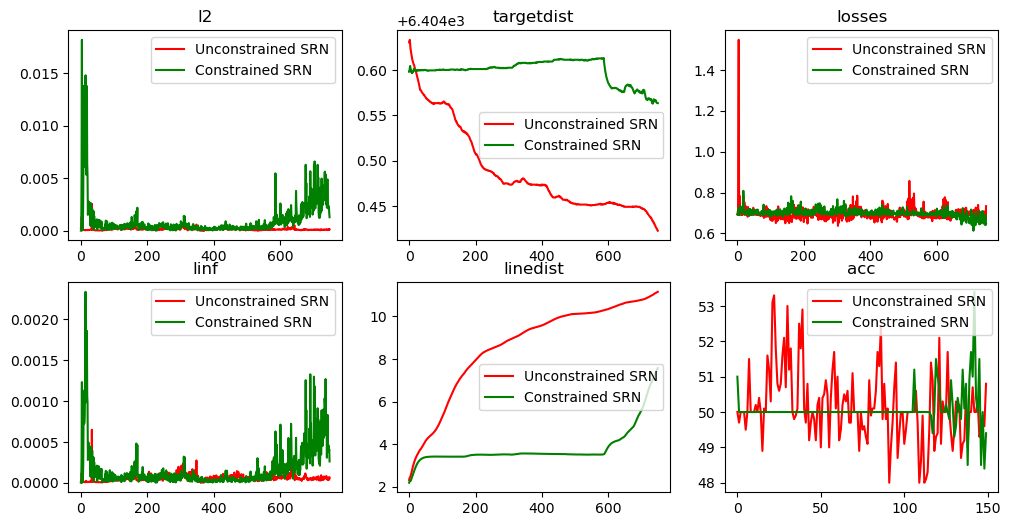

16.16.SP.2.1.0


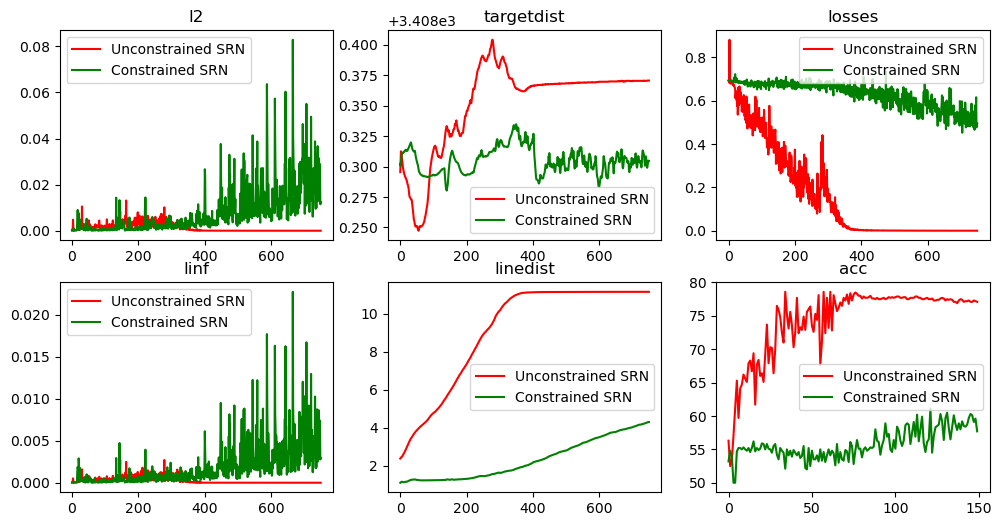

64.64.SF.0.0.0 not found...
64.64.SL.4.1.0 not found...


In [17]:
for name in names:
    try:
        statsnoparam, statsparam = all_stats[name]
    #utils.plot_stats(statsnoparam)
    #utils.plot_stats(statsparam)
        print(name)
        utils.plot_stats(statsnoparam, statsparam)
    except KeyError:
        print(name, "not found...")